# Setup libraries

In [1]:
!pip install --upgrade pip
!pip uninstall -y transformers tokenizers accelerate -q
!pip install "transformers==4.56.0" "protobuf==5.29.3" -q
!pip install torch datasets -q
!pip install pandas matplotlib seaborn tqdm wandb pyyaml
!pip install bitsandbytes accelerate
!pip install --force-reinstall --no-cache-dir "numpy<2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 5.29.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 

# Config input/output path and clone latest repo

In [2]:
# Clone the latest github repo version
import os
def configure_environment_paths():
    """Detect environment and configure paths"""
    try:
        if "google.colab" in str(get_ipython()):
            print("✅ Environment: Google Colab")
            base_data_path = "/content/"
            base_output_path = "/content/output/"
            environment_name = "colab"
        elif os.environ.get("KAGGLE_KERNEL_RUN_TYPE"):
            print("✅ Environment: Kaggle")
            base_data_path = "/kaggle/input/"
            base_output_path = "/kaggle/working/"
            environment_name = "kaggle"
        else:
            print("⚠️ Environment: Local/Unknown")
            base_data_path = "./data/"
            base_output_path = "./output/"
            environment_name = "local"
    except NameError:
        print("⚠️ Non-interactive session. Using local paths.")
        base_data_path = "./data/"
        base_output_path = "./output/"
        environment_name = "local"

    os.makedirs(base_output_path, exist_ok=True)
    print(f"📂 Data Path: {base_data_path}")
    print(f"📦 Output Path: {base_output_path}")

    return base_data_path, base_output_path, environment_name

INPUT_PATH, OUTPUT_PATH, ENV_NAME = configure_environment_paths()

!rm -r -f OuroTrace
!git clone --branch claude https://github.com/dzungphieuluuky/OuroTrace.git
%cd OuroTrace

✅ Environment: Kaggle
📂 Data Path: /kaggle/input/
📦 Output Path: /kaggle/working/
Cloning into 'OuroTrace'...
remote: Enumerating objects: 482, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 482 (delta 117), reused 106 (delta 56), pack-reused 296 (from 1)
Receiving objects: 100% (482/482), 1.23 MiB | 10.31 MiB/s, done.
Resolving deltas: 100% (283/283), done.
/kaggle/working/OuroTrace


In [3]:
# Suppress warnings for clean output
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"
print("✅ Packages installed successfully!")

✅ Packages installed successfully!


In [4]:
"Built-in libraries"
import re
import sys
import gc
import time
import json
import hashlib
import glob
import zipfile
from io import StringIO
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
import yaml
import logging
import random

"Deep learning and NLP libraries"
import torch
import torch.nn.functional as F
from transformers import (
    AutoConfig, 
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig,
    logging as hf_logging
)

"Data processing libraries"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from tqdm.auto import tqdm
from IPython import get_ipython

# Configure logging
logging.getLogger("ContinuousBatchingLogger").setLevel(logging.ERROR)
hf_logging.set_verbosity_error()


print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
!nvidia-smi

Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
Tue Dec 16 08:14:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|   

In [5]:
import pandas as pd
from src.config_loader import load_config_from_json, post_process_config
from src.runner import run_batch_experiment
from src.evaluation import analyze_experiment_results


# 1. Load Configuration from JSON
config = load_config_from_json('configs/batch_ouro_1.4b_thinking.json')

# 2. Post-process (Convert 'torch.float16' string to object, generate timestamps)
config = post_process_config(config)

config["INFERENCE_STEPS"] = [4]
config["reasoning_primitives"]["num_samples"] = 5

# 4. Execute
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"🕒 Timestamp: {timestamp}")
print("🚀 Starting Experiment...")
acc_results, ppl_results, hol_results = run_batch_experiment(config)

🕒 Timestamp: 20251216_081435
🚀 Starting Experiment...
🔗 Initializing W&B (timeout: 30s)...
⚠️ W&B initialization failed: 1 validation error for Settings
start_timeout
  Extra inputs are not permitted [type=extra_forbidden, input_value=30, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden. Continuing offline.

🔧 EXPERIMENT CONFIGURATION
Model Path: ByteDance/Ouro-1.4B-Thinking
UT Steps to Test: [4]
Data Type: torch.float16
4-bit Quantization: False
Torch Compile: False
Max Batch Size: 8
Max New Tokens: 512
Enable Batching: True
Calculate Perplexity: True
Early Exit Threshold: 1.0

🎲 Random seed set to 42

📦 LOADING TEST DATASETS
⚙️ Generating new test datasets...
✅ Generated test datasets

Dataset Summary:
   n_ary       :   24 samples
   p_hop       :   24 samples
   igsm        :    8 samples

📚 Preparing perplexity evaluation data...
✅ Prepared 50 samples for PPL


🧪 EXPERIMENT 1/1: UT Steps = 4


⚙️  LOADING MODEL CONFIGURATION
Mode

config.json: 0.00B [00:00, ?B/s]

configuration_ouro.py: 0.00B [00:00, ?B/s]


→ Base config loaded
   Original UT steps: 4
   Original early exit: 1.0

→ Modified config:
   New UT steps: 4
   New early exit: 1.0


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]


→ Tokenizer loaded
   Vocab size: 49152
   PAD token: <|im_end|>
   EOS token: <|im_end|>

→ Loading model weights...


modeling_ouro.py: 0.00B [00:00, ?B/s]

2025-12-16 08:14:40.505059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765872880.877764      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765872880.990419      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/2.87G [00:00<?, ?B/s]


✅ MODEL LOADED SUCCESSFULLY
Device: cuda:0
Model dtype: torch.float16
VERIFIED UT steps: 4
VERIFIED early exit: 1.0

🔧 Building task templates...
[+] Task templates pre-computed successfully

📉 PERPLEXITY EVALUATION



Calculating PPL (UT=4):   0%|          | 0/8 [00:00<?, ?it/s]


✅ Perplexity Results:
   Perplexity: 1.6052
   Avg Loss:   0.4732

🎯 ACCURACY EVALUATION


──────────────────────────────────────────────────────────────────────
📝 Task: N_ARY
──────────────────────────────────────────────────────────────────────
Total Samples: 24
Batch Size: 8
Strategy: Batched Processing

Running 3 batches...


   n_ary:   0%|          | 0/3 [00:00<?, ?it/s]


Solving 8 requests: 100%|██████████| 8/8 [01:15<00:00,  9.42s/request]

Solving 8 requests: 100%|██████████| 8/8 [01:13<00:00,  9.24s/request]

Solving 8 requests: 100%|██████████| 8/8 [01:22<00:00, 10.31s/request]


⚠️ GARBAGE OUTPUT detected in batch for n_ary (idx=6)

──────────────────────────────────────────────────────────────────────
📊 Summary for N_ARY
──────────────────────────────────────────────────────────────────────
Accuracy:              4.17% (1/24)
Garbage Outputs:          1 (4.2%)
Avg Gen Time:         9.678s
Avg Tokens:           416.9
Total Duration:       232.3s
Throughput:            0.10 samples/sec
──────────────────────────────────────────────────────────────────────

📋 Detailed Results for N_ARY:
──────────────────────────────────────────────────────────────────────
                                        test_input                                      full_response expected_answer prediction  is_correct  is_degenerate
                           097 + 857 + 968 + 085 = [STEP 1]  Current: 0[STEP 2] Add 097: 0 + 097 =...            2007        094       False          False
                           520 + 599 + 023 + 558 = [STEP 1]  Current: 0[STEP 2] Add 520: 0 + 520 =...

   p_hop:   0%|          | 0/6 [00:00<?, ?it/s]


Solving 4 requests: 100%|██████████| 4/4 [01:12<00:00, 18.16s/request]


⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=1)
⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=2)



Solving 4 requests: 100%|██████████| 4/4 [00:05<00:00,  1.46s/request]

Solving 4 requests: 100%|██████████| 4/4 [01:12<00:00, 18.25s/request]

Solving 4 requests: 100%|██████████| 4/4 [01:13<00:00, 18.33s/request]


⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=1)



Solving 4 requests: 100%|██████████| 4/4 [01:12<00:00, 18.21s/request]


⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=2)
⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=3)



Solving 4 requests: 100%|██████████| 4/4 [01:13<00:00, 18.30s/request]

⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=3)
⚠️ GARBAGE OUTPUT detected in batch for p_hop (idx=2)

──────────────────────────────────────────────────────────────────────
📊 Summary for P_HOP
──────────────────────────────────────────────────────────────────────
Accuracy:              8.33% (2/24)
Garbage Outputs:          7 (29.2%)
Avg Gen Time:        15.490s
Avg Tokens:           281.4
Total Duration:       371.8s
Throughput:            0.06 samples/sec
──────────────────────────────────────────────────────────────────────

📋 Detailed Results for P_HOP:
──────────────────────────────────────────────────────────────────────
                                        test_input                                      full_response expected_answer prediction  is_correct  is_degenerate
Sequence: BAABCCBCDCABCABBCCBCCADADDDCDCBCDCBDBCBA [TRACE]  Start at A. Found 'A' in sequence. Nex...               C          B       False          False
Sequence: ABAACAABADCBCBDDDDDDDDCCDADBADADABBC

   igsm:   0%|          | 0/4 [00:00<?, ?it/s]


Solving 2 requests: 100%|██████████| 2/2 [01:11<00:00, 36.00s/request]

Solving 2 requests: 100%|██████████| 2/2 [01:11<00:00, 35.93s/request]


⚠️ GARBAGE OUTPUT detected in batch for igsm (idx=1)



Solving 2 requests: 100%|██████████| 2/2 [01:13<00:00, 36.52s/request]

Solving 2 requests: 100%|██████████| 2/2 [01:12<00:00, 36.29s/request]


──────────────────────────────────────────────────────────────────────
📊 Summary for IGSM
──────────────────────────────────────────────────────────────────────
Accuracy:             25.00% (2/8)
Garbage Outputs:          1 (12.5%)
Avg Gen Time:        36.262s
Avg Tokens:           512.0
Total Duration:       290.1s
Throughput:            0.03 samples/sec
──────────────────────────────────────────────────────────────────────

📋 Detailed Results for IGSM:
──────────────────────────────────────────────────────────────────────
                                        test_input                                      full_response expected_answer prediction  is_correct  is_degenerate
Question. G#K := 6. L#I := L#L. L#L := N#A. N#A := [EQ 1]  G#K/R...r/r/r/r/r/r/r/r/r/r/r/r/r/r/r/r...               3          1       False          False
Question. L#G := M#O. M#O := L#J. A#D := 1. L#P := [EQ 1]  L#G =G?=G=M=G?=M=M?=G?=M?=P?=G??=M?=P?=...               4          1       False          False
Q

var_assign_depth_0_code:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_0_math (5 samples)


var_assign_depth_0_math:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_0_equation (5 samples)


var_assign_depth_0_equation:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_1_code (5 samples)


var_assign_depth_1_code:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_1_math (5 samples)


var_assign_depth_1_math:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%
  Task: var_assign_depth_1_equation (5 samples)


var_assign_depth_1_equation:   0%|          | 0/5 [00:00<?, ?it/s]

    ✅ Accuracy: 0.00%

📚 Running Standard Benchmarks (lm-eval)
⚠️ 'lm-evaluation-harness' not installed. Skipping Standard Benchmarks.
ℹ️ To run: pip install lm-evaluation-harness
⚠️ Holistic evaluation failed: list indices must be integers or slices, not str

🧹 Cleaning up GPU memory...
✅ GPU memory freed


📊 FINAL EXPERIMENT SUMMARY

⚠️ WARNING: 9 garbage/degenerate outputs detected

📈 Overall Accuracy by Task Type:
──────────────────────────────────────────────────────────────────────
          Accuracy   N
task_type             
igsm        25.00%   8
n_ary        4.17%  24
p_hop        8.33%  24

📈 Accuracy by UT Steps:
──────────────────────────────────────────────────────────────────────
         Accuracy   N
ut_steps             
4           8.93%  56

📈 Accuracy by Task Type and UT Steps:
──────────────────────────────────────────────────────────────────────
ut_steps       4
task_type       
igsm       25.00
n_ary       4.17
p_hop       8.33

📉 Perplexity by UT Steps:
────────


💾 Results saved to /kaggle/working/

📊 VISUALIZATION

--- Summary Statistics ---
                    is_correct_mean  is_correct_count  is_correct_std  \
ut_steps task_type                                                      
4        igsm                 0.250                 8           0.463   
         n_ary                0.042                24           0.204   
         p_hop                0.083                24           0.282   

                    generation_time_mean  generation_time_min  \
ut_steps task_type                                              
4        igsm                     36.262               36.008   
         n_ary                     9.678                9.260   
         p_hop                    15.490                1.495   

                    generation_time_max  generated_tokens_mean  
ut_steps task_type                                              
4        igsm                    36.597                512.000  
         n_ary                 

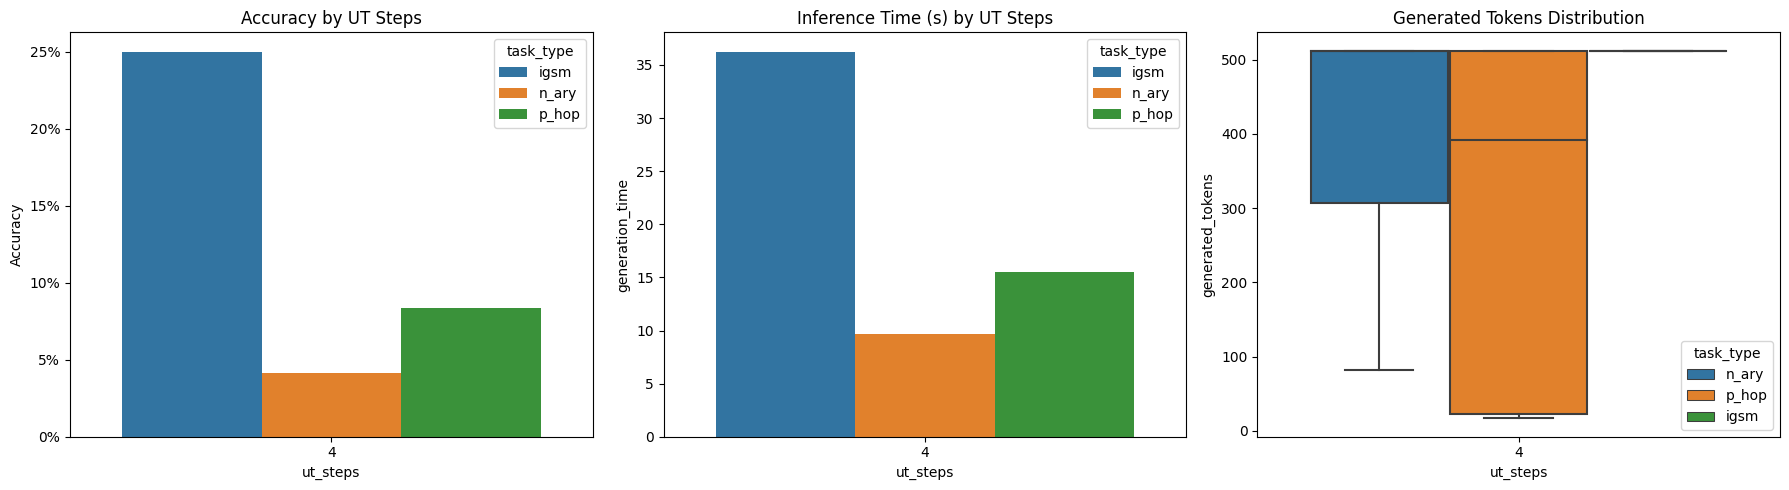


🏁 Experiment Complete.



In [6]:
# 3. Save Results
df_acc = pd.DataFrame(acc_results)
df_ppl = pd.DataFrame(ppl_results)
df_hol = pd.DataFrame(hol_results)
RUN_RESULTS_NAME = f"run_{timestamp}"
os.makedirs(os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME), exist_ok=True)
acc_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_acc_{timestamp}.csv")
ppl_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_ppl_{timestamp}.csv")
hol_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_hol_{timestamp}.csv")
cfg_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_config_{timestamp}.yaml")

df_acc.to_csv(acc_path, index=False)
if not df_ppl.empty:
    df_ppl.to_csv(ppl_path, index=False)
if not df_hol.empty:
    df_hol.to_csv(hol_path, index=False)
# Save Config
def sanitize_config(cfg):
    """Convert config to YAML-safe format"""
    clean = {}
    for k, v in cfg.items():
        if isinstance(v, dict):
            clean[k] = sanitize_config(v)
        elif str(type(v)).find('torch.') != -1:
            clean[k] = str(v)
        else:
            clean[k] = v
    return clean

with open(cfg_path, 'w') as f:
    yaml.dump(sanitize_config(config), f)

print(f"\n💾 Results saved to {OUTPUT_PATH}")

# 4. Visualization & Reporting
if not df_acc.empty:
    print("\n" + "="*50 + "\n📊 VISUALIZATION\n" + "="*50)
    
    # Summary Tables
    # NOTE: The variable 'results_acc' is used here, assuming it holds the raw data 
    # (list of dicts) required by 'analyze_experiment_results'.
    summary = analyze_experiment_results(acc_results)
    print("\n--- Summary Statistics ---")
    print(summary)
    
    # Plotting
    try:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot 1: Accuracy
        acc_summary = df_acc.groupby(['task_type', 'ut_steps'])['is_correct'].mean().reset_index()
        sns.barplot(data=acc_summary, x='ut_steps', y='is_correct', hue='task_type', ax=axes[0])
        axes[0].set_title('Accuracy by UT Steps')
        axes[0].set_ylabel('Accuracy')
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        # Plot 2: Time
        time_summary = df_acc.groupby(['task_type', 'ut_steps'])['generation_time'].mean().reset_index()
        sns.barplot(data=time_summary, x='ut_steps', y='generation_time', hue='task_type', ax=axes[1])
        axes[1].set_title('Inference Time (s) by UT Steps')
        
        # Plot 3: Token Count
        sns.boxplot(data=df_acc, x='ut_steps', y='generated_tokens', hue='task_type', ax=axes[2])
        axes[2].set_title('Generated Tokens Distribution')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Visualization error: {e}")
else:
    print("⚠️ No results to visualize.")

print("\n🏁 Experiment Complete.\n")

In [7]:
import os
import glob
import zipfile

def zip_all_run_folders(output_base_path: str):
    os.makedirs(output_base_path, exist_ok=True)
    
    search_pattern = os.path.join(output_base_path, "run_*")
    run_folders = glob.glob(search_pattern)
    run_directories = [d for d in run_folders if os.path.isdir(d)]

    if not run_directories:
        print(f"⚠️ Không tìm thấy thư mục nào bắt đầu bằng 'run_' trong '{output_base_path}'.")
        return

    print(f"🔍 Tìm thấy {len(run_directories)} thư mục kết quả để nén.")
    
    successful_zips = 0

    for folder_path in run_directories:
        folder_name = os.path.basename(folder_path)
        zip_filename = os.path.join(output_base_path, f"{folder_name}.zip")
        
        try:
            print(f"\n   -> Đang nén thư mục: {folder_name}...")
            
            with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
                for root, _, files in os.walk(folder_path):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, os.path.dirname(folder_path))
                        zipf.write(file_path, arcname)
                        
            print(f"   ✅ Đã tạo file ZIP: {os.path.basename(zip_filename)}")
            successful_zips += 1
            
        except Exception as e:
            print(f"   ❌ Lỗi khi nén thư mục {folder_name}: {e}")

    print(f"\n✅ HOÀN TẤT! Đã nén thành công {successful_zips} trên {len(run_directories)} thư mục kết quả.")


try:
    if 'OUTPUT_PATH' in globals():
        zip_all_run_folders(OUTPUT_PATH)
    else:
        print("OUTPUT_PATH not defined.")
        
except NameError:
    print("OUTPUT_PATH not defined.")
except Exception as e:
    print(f"Đã xảy ra lỗi trong quá trình nén: {e}")

🔍 Tìm thấy 1 thư mục kết quả để nén.

   -> Đang nén thư mục: run_20251216_081435...
   ✅ Đã tạo file ZIP: run_20251216_081435.zip

✅ HOÀN TẤT! Đã nén thành công 1 trên 1 thư mục kết quả.


In [8]:
print("Final Inspection:\n")
print("Top 20 Accuracy Report:\n")
print(df_acc.head(20))
print(f"Full Response:\n")
print(df_acc['full_response'])
print("Perplexity Report:\n")
print(df_ppl.head(20))

Final Inspection:

Top 20 Accuracy Report:

   task_type difficulty                                         test_input  \
0      n_ary      4_ops                            097 + 857 + 968 + 085 =   
1      n_ary      4_ops                            520 + 599 + 023 + 558 =   
2      n_ary      4_ops                            528 + 760 + 207 + 401 =   
3      n_ary      4_ops                            001 + 018 + 330 + 471 =   
4      n_ary      4_ops                            574 + 901 + 326 + 125 =   
5      n_ary      4_ops                            108 + 634 + 466 + 981 =   
6      n_ary      4_ops                            881 + 277 + 070 + 228 =   
7      n_ary      4_ops                            208 + 666 + 543 + 442 =   
8      n_ary      8_ops    851 + 963 + 972 + 793 + 976 + 389 + 773 + 605 =   
9      n_ary      8_ops    399 + 458 + 532 + 756 + 866 + 209 + 564 + 893 =   
10     n_ary      8_ops    660 + 260 + 851 + 441 + 769 + 076 + 605 + 691 =   
11     n_ary      8_

In [9]:
print(df_acc[['full_response', 'generated_tokens']])

                                        full_response  generated_tokens
0   [STEP 1]  Current: 0[STEP 2] Add 097: 0 + 097 ...               512
1   [STEP 1]  Current: 0[STEP 2] Add 520: 0 + 520 ...               173
2   [STEP 1]  Current: 0[STEP 2] Add 528: 0 + 528 ...               512
3   [STEP 1]  Current: 0[STEP 2] Add 010: 0 + 010 ...               512
4   [STEP 1]  Current: 0[STEP 2] Add 1: 57 10 = 10...                82
5   [STEP 1]  Current: 0[STEP 2] Add 10: 10: 0 + 1...               390
6   [STEP 1]  Current: 0[STEP 2] Add 888: 0 + 888 ...               512
7   [STEP 1]  Current: 0[STEP 2] Add 208: 0 + 208 ...               156
8   [STEP 1]  Current::::::::::::::::::::ic:ic:ic:...               512
9   [STEP 1]  Current: 0[STEP 2] Add 399: 0 + 399 ...               236
10  [STEP 1]  Current: 0[STEP 2] Add 660: 0 + 660 ...               512
11  [STEP 1]  Current: 0[STEP 2] Add 483: 0 + 483 ...               512
12  [STEP 1]  Current: 0[STEP 2] Add 10: 0 + 10 = ...           